In [25]:
#using Isolation Forest algorithm (unsupervised learning models)
# we are doing anomaly detection on car data saved in data.csv file
# Mainly anomaly is detected on all  the features present inside data.csv :

In [26]:
#-----------------------------
# Required Imports
#-----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from joblib import dump


In [27]:

#-----------------------------
# Load and Clean Dataset
#-----------------------------
df = pd.read_csv("data.csv")
features = ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
            'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
            'Number of Doors', 'Market Category', 'Vehicle Size',
            'Vehicle Style', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']

df_clean = df[features].dropna().reset_index(drop=True)


In [28]:
#data head print
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [29]:
#-----------------------------
# Simulate Ground Truth Labels
#-----------------------------
np.random.seed(42)
df_clean['true_label'] = 0  # 0 = normal
anomaly_indices = np.random.choice(df_clean.index, size=int(0.02 * len(df_clean)), replace=False)
df_clean.loc[anomaly_indices, 'true_label'] = 1  # 1 = anomaly


In [30]:
#-----------------------------
# Separate Feature Types
#-----------------------------
categorical_features = df_clean[features].select_dtypes(include=['object']).columns.tolist()
numerical_features = df_clean[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

#-----------------------------
# Build Preprocessing Pipeline
#-----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [31]:
#-----------------------------
# Apply Transformation
#-----------------------------
X_scaled = preprocessor.fit_transform(df_clean[features])


In [32]:
#-----------------------------
# Train Isolation Forest Model
#-----------------------------
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_clean['pred_label'] = iso_model.fit_predict(X_scaled)
df_clean['pred_label'] = df_clean['pred_label'].map({1: 0, -1: 1})  # 0 = normal, 1 = anomaly


Confusion Matrix
[[7526  397]
 [ 155    6]]


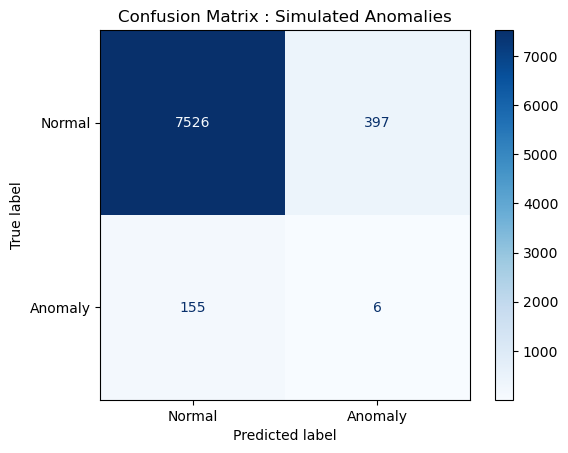


Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96      7923
     Anomaly       0.01      0.04      0.02       161

    accuracy                           0.93      8084
   macro avg       0.50      0.49      0.49      8084
weighted avg       0.96      0.93      0.95      8084



In [33]:
#-----------------------------
# Evaluation Metrics
#-----------------------------
cm = confusion_matrix(df_clean['true_label'], df_clean['pred_label'])
print("Confusion Matrix")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix : Simulated Anomalies")
plt.grid(False)
plt.show()

print("\nClassification Report:\n")
print(classification_report(df_clean['true_label'], df_clean['pred_label'], target_names=["Normal", "Anomaly"]))


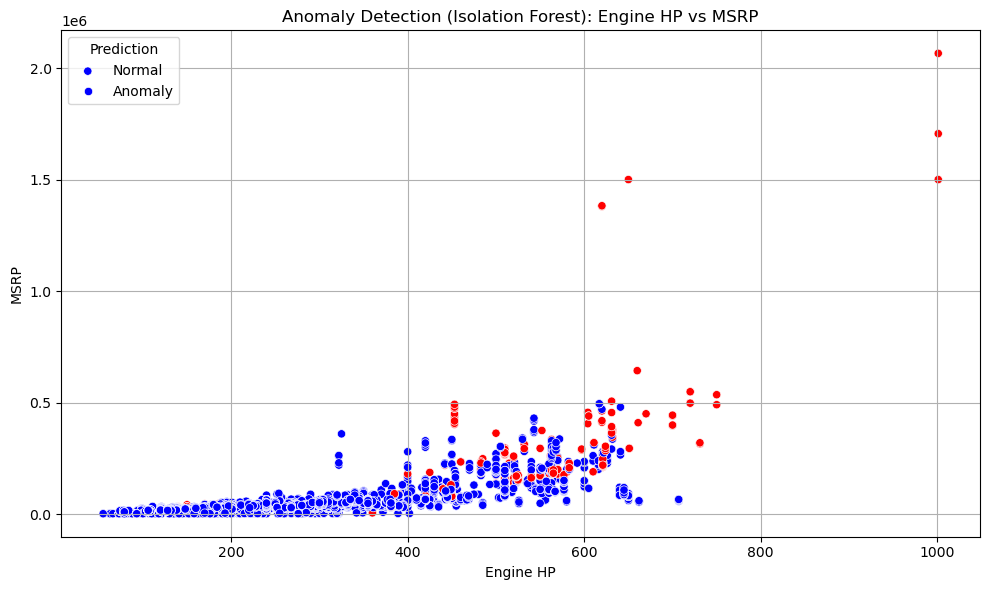

In [34]:
#-----------------------------
# Visualize Detected Anomalies
#-----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_clean['Engine HP'],
    y=df_clean['MSRP'],
    hue=df_clean['pred_label'],
    palette=['blue', 'red']
)
plt.title("Anomaly Detection (Isolation Forest): Engine HP vs MSRP")
plt.xlabel("Engine HP")
plt.ylabel("MSRP")
plt.legend(title="Prediction", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
#Save the models (.pkl)
#######################
dump(iso_model,'isolation_forest_model.pkl')
print("Model saved as isolation_forest_model.pkl")

Model saved as isolation_forest_model.pkl


In [36]:
df_clean.to_csv("anomaly_detection_output.csv",index = False)
print("Labeled data saved to anomaly_detection_output.csv")

Labeled data saved to anomaly_detection_output.csv
